Tutorial followed: https://learn.microsoft.com/en-us/training/modules/intro-natural-language-processing-tensorflow/2-represent-text-as-tensors

In [1]:
!pip install tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

# In this tutorial, we will be training a lot of models. In order to use GPU memory cautiously,
# we will set tensorflow option to grow GPU memory allocation when required.
physical_devices = tf.config.list_physical_devices('GPU') 
if len(physical_devices)>0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

dataset = tfds.load('ag_news_subset')

In [3]:
ds_train = dataset['train']
ds_test = dataset['test']

In [4]:
import os
import nltk
from nltk.tokenize import sent_tokenize
from statistics import mean 
import time

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
def read_text(text):
    def word_count(str):
        """
        turns a string into counts, return a dict
        """
        counts = dict()
        words = str.split()
        for word in words:
            counts[word] = counts.get(word, 0) + 1
        return counts

    extracted = {}
    tensor = []

    d = word_count(text)
    tokens = sent_tokenize(text)
    special_char = [c for c in text if not c.isalpha() and not c.isdigit() and c != '\n' and c!=' ']
            
    TOTAL_WORD_COUNT = sum(d.values())
    UNIQUE_WORD_COUNT = len(d.values())
    NO_SENTENCES = len(tokens)
    AVG_LEN_SENTENCES_CHAR = sum(map(len, tokens))/len(tokens)
    AVG_LEN_SENTENCES_WORD = mean([len(s.split()) for s in tokens])
    SPECIALS = len(special_char)

    # set some max values so I can normalize the data
    if( TOTAL_WORD_COUNT > 500 ):
      tensor.append(1)
    else:
      tensor.append(TOTAL_WORD_COUNT/500)

    if( UNIQUE_WORD_COUNT > 500 ):
      tensor.append(1)
    else:
      tensor.append(UNIQUE_WORD_COUNT/500)

    if( NO_SENTENCES > 500 ):
      tensor.append(1)
    else:
      tensor.append(NO_SENTENCES/500)

    if( AVG_LEN_SENTENCES_CHAR > 500 ):
      tensor.append(1)
    else:
      tensor.append(AVG_LEN_SENTENCES_CHAR/500)

    if( AVG_LEN_SENTENCES_WORD > 500 ):
      tensor.append(1)
    else:
      tensor.append(AVG_LEN_SENTENCES_WORD/500)

    if( SPECIALS > 500 ):
      tensor.append(1)
    else:
      tensor.append(SPECIALS/500)
    
    return tensor

In [57]:
# 0 World, 1 Sports, 2 Business, 3 Sci/Tech
training_in = []
training_out = []
test_in = []
test_out = []

c = 0
CAP = 50000
for x in ds_train:
  if(c < CAP):
    arr = read_text(str(x['description'].numpy()))
    tensor = tf.convert_to_tensor(arr, dtype=float)
    training_in.append(arr)
    training_out.append(int(x['label'].numpy()))
    c += 1

  if(c == CAP):
    break

d = 0
for x in ds_test:
  if(d < CAP):
    arr = read_text(str(x['description'].numpy()))
    tensor = tf.convert_to_tensor(arr, dtype=float)
    test_in.append(arr)
    test_out.append(int(x['label'].numpy()))
    d += 1

  if(d == CAP):
    break

In [58]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

# based on https://medium.com/geekculture/how-to-plot-model-loss-while-training-in-tensorflow-9fa1a1875a5
# will eventually write my own
class PlotLearning(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []

    def on_epoch_end(self, epoch, logs={}):
        print(logs)
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            print(metric, self.metrics[metric])
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

loss [1.3943225145339966]
acc [0.2454800009727478]


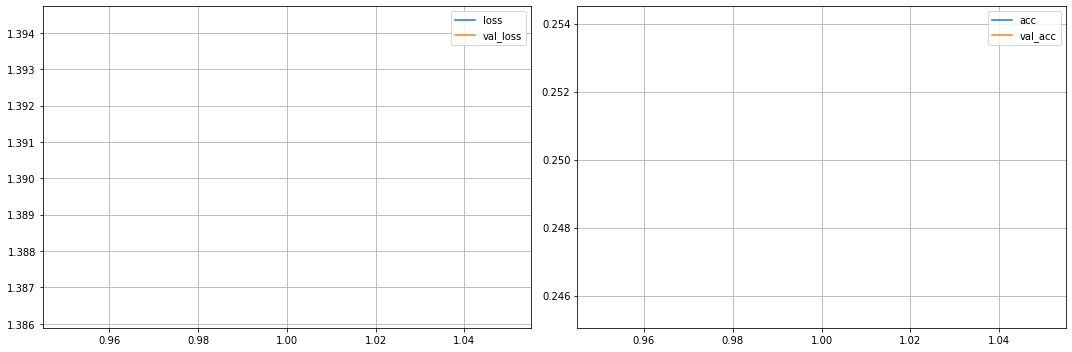

1563/1563 [==============================] - 9s 5ms/step - loss: 1.3943 - acc: 0.2455 - val_loss: 1.3863 - val_acc: 0.2541
Epoch 2/10
 208/1563 [==>...........................] - ETA: 4s - loss: 1.3863 - acc: 0.2422

KeyboardInterrupt: ignored

In [62]:
# Create the model
model = keras.models.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(256, activation=tf.nn.relu),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(4)
])

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['acc'])
model.fit(training_in, training_out, epochs=10, validation_data=(test_in, test_out), callbacks=[PlotLearning()])

***Important, generalizable step:***

```
keras.layers.experimental.preprocessing.TextVectorization(max_tokens=vocab_size)```

In [ ]:
vocab_size = 50000
vectorizer = keras.layers.experimental.preprocessing.TextVectorization(max_tokens=vocab_size)
vectorizer.adapt(ds_train.take(500).map(lambda x: x['title']+' '+x['description']))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
vocab = vectorizer.get_vocabulary()
vocab_size = len(vocab)

In [ ]:
# Above steps can be used to vectorize sentences
print(vectorizer('I love to play with my words')) # Given sample
print(vectorizer('This is a sentence and I do not know what it means.')) # A random sentence

tf.Tensor([ 112 3695    3  304   11 1041    1], shape=(7,), dtype=int64)
tf.Tensor([  35   17    4    1    7  112  828   57 3787  333   22    1], shape=(12,), dtype=int64)


In [ ]:
def to_bow(text): # "basket of words"
    return tf.reduce_sum(tf.one_hot(vectorizer(text),vocab_size),axis=0)

batch_size = 128

ds_train_bow = ds_train.map(lambda x: (to_bow(x['title']+x['description']),x['label'])).batch(batch_size)
ds_test_bow = ds_test.map(lambda x: (to_bow(x['title']+x['description']),x['label'])).batch(batch_size)

In [ ]:
# Here is where the tutorial trains an actual model
model = keras.models.Sequential([
    keras.layers.Dense(4,activation='softmax',input_shape=(vocab_size,)) # Notice that the model is only one layer – can we add more? Why is it only one?
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['acc']) # Generic compile
model.fit(ds_train_bow,validation_data=ds_test_bow, callbacks=[PlotLearning()], epochs=8)

Epoch 1/8
 24/938 [..............................] - ETA: 58s - loss: 1.3169 - acc: 0.4535

KeyboardInterrupt: ignored

loss [0.41535067558288574, 0.285577654838562, 0.2335778921842575, 0.18426838517189026, 0.14555267989635468, 0.1163056492805481, 0.09427235275506973, 0.07717189192771912, 0.0651000514626503, 0.05551719292998314, 0.049127984791994095, 0.04225940257310867, 0.03811970353126526, 0.03436705470085144, 0.03243783116340637, 0.02913065254688263, 0.026503335684537888, 0.024811584502458572, 0.023666132241487503, 0.021044163033366203, 0.020399702712893486, 0.019199585542082787, 0.01863493211567402, 0.01740446500480175, 0.017279118299484253, 0.01592548005282879, 0.014889374375343323, 0.015244665555655956, 0.013938892632722855, 0.013692941516637802]
acc [0.8551499843597412, 0.9010999798774719, 0.9188166856765747, 0.9351333379745483, 0.9480916857719421, 0.9579916596412659, 0.965708315372467, 0.971666693687439, 0.9764416813850403, 0.9801666736602783, 0.9830999970436096, 0.9848166704177856, 0.9868916869163513, 0.9881083369255066, 0.9890000224113464, 0.9900416731834412, 0.9911749958992004, 0.991675019264

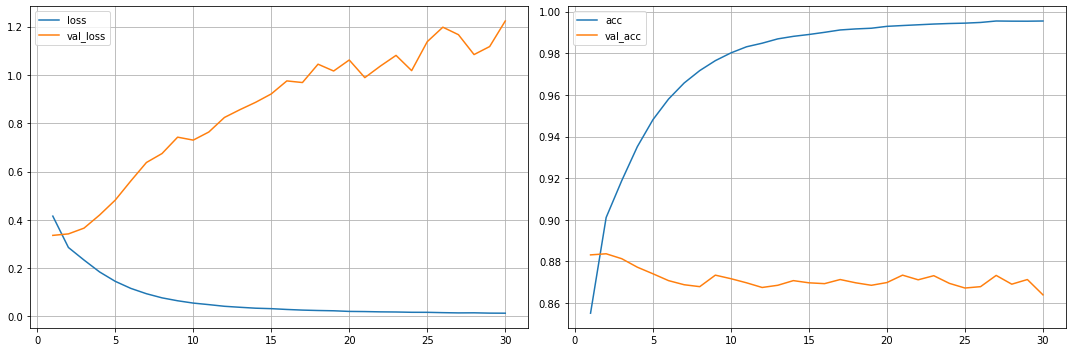

938/938 [==============================] - 64s 68ms/step - loss: 0.0137 - acc: 0.9955 - val_loss: 1.2228 - val_acc: 0.8639


In [ ]:
# Let's try a new model, this time with more layers
model = keras.models.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(256, activation=tf.nn.relu),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(4,activation='softmax',input_shape=(vocab_size,))
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['acc'])
model.fit(ds_train_bow,validation_data=ds_test_bow, callbacks=[PlotLearning()], epochs=30)